In [ ]:
import numpy as np 
from torch import nn
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from torch.optim import Adam
from torch.nn import MSELoss,HuberLoss
from torch.nn import init
from gymnasium.wrappers import RecordVideo
from Exploration.EpsilonGreedyExploration import epsilon_decay,epsilon_greedy,linear_epsilon_decay
from Buffers.ExperienceReplayBuffer import ExperienceReplay
# from Buffers.ExperienceReplayBuffer import ExperienceReplay


In [13]:
ENV_NAME ="CartPole-v1"
SEED = 13 
LEARNING_RATE = 1e-3
BUFFER_SIZE =20000
GAMMA = 0.99
EPISODES= 701
STEPS=1000
BATCH_SIZE = 64
EPSILON=1.0

<center><b>Test and Explore Environment

action_num = 2 | state num = 4


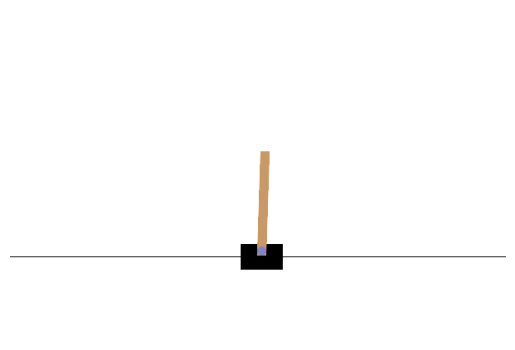

In [14]:
import random
random.seed(13)

env = gym.make(ENV_NAME,render_mode="rgb_array")
video_directory = f'./videos/{ENV_NAME}'
env = RecordVideo(env, video_directory, episode_trigger=lambda episode_id: episode_id % 25 == 0, fps=15)
env.reset(seed=SEED)
state_num  = env.observation_space.shape[0]
action_num= env.action_space.n
print(f"action_num = {action_num} | state num = {state_num}")
plt.imshow(env.render())
plt.axis('off');

In [15]:
from ast import mod


class QNetfork (nn.Module):
    def __init__(self,input_num,h1,h2,h3,output_num):
        super().__init__()
        self.linear1 = nn.Linear(input_num,h1)
        self.linear2 = nn.Linear(h1,h2)
        self.linear3 = nn.Linear(h2,h3)
        self.linear4 = nn.Linear(h3,output_num)
        
        self.init_weight()
        
    def init_weight(self):
        for module in self.modules():
            if isinstance(module,nn.Linear):
                init.kaiming_normal_(module.weight,nonlinearity="relu")
                if module.bias is not None:
                    init.constant_(module.bias,0)
            
    def forward(self,x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = self.linear4(x)
        return x 

In [16]:
device = ("cuda:0"if torch.cuda.is_available() else "cpu" )
from torchsummary import summary
torch.manual_seed(SEED)
model = QNetfork(state_num,256,128,64,action_num).to((device))
target_model = QNetfork(state_num,256,128,64,action_num).to((device))
target_model.load_state_dict(model.state_dict())
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)
buffer = ExperienceReplay(BUFFER_SIZE)
summary(model,(state_num,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           1,280
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                    [-1, 2]             130
Total params: 42,562
Trainable params: 42,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [ ]:
only_exploit = False
rewards = []
total_steps=0
for episode in range(EPISODES):
    
    total_reward = 0
    old_observation , _ =env.reset(seed=SEED) 
    
    if episode % 50 == 0 :
        only_exploit = True
    else:
        only_exploit = False
    
    
    for step in range(STEPS):
        obs = torch.tensor(old_observation).float().reshape(1,-1).to((device))
        action_values = model(obs).detach().squeeze()
        action = epsilon_greedy(action_values,EPSILON,only_exploit) #explore works
        
        new_observation ,reward,terminated,truncated,_ = env.step(action)
        
        done =  truncated or terminated 
    
        buffer.append(old_observation,action,reward,new_observation,done) 
        old_observation = new_observation
        total_reward+=reward
        
        if(buffer.size() >= BATCH_SIZE):
            old_state,Action,batch_reward,new_state,done = buffer.sample(BATCH_SIZE)
            
            old_state=old_state.float().to((device))
            new_state=new_state .float().to((device))
            Action=Action .long().reshape(-1,1).to((device)) # it should be two dimension for gathering
            batch_reward=batch_reward.reshape(-1,1) .float().to((device))
            done=done.reshape(-1,1).float().to((device))
            
            q_value = model(old_state)
            q_value = q_value.gather(1, Action)
            
            with torch.no_grad():
                q_value_target= target_model(new_state)
                best_action = torch.argmax(q_value_target,dim=1).reshape(-1,1).long()
                q_value_target = q_value_target.gather(1, best_action)
                target = batch_reward + GAMMA * q_value_target*(1-done)
                
            loss = criterion(q_value,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_steps+=1   
        if truncated or terminated:
            break
        
    rewards.append(total_reward)
    if  episode % 5  == 0:
        print("Target Updated")
        target_model.load_state_dict(model.state_dict())
    if only_exploit:
        print(f"Exploit Result = {total_reward}")
    #decay = 1/(EPISODES*0.9) # 90 percent of episodes will decrease
    EPSILON = epsilon_decay(EPSILON,0.985,0.01)
    print(f"Episode {episode:4d} | Reward: {total_reward:.2f} | Epsilon: {EPSILON:.3f}")
    
# import os 
# os.mkdir(f"./{ENV_NAME}")
# torch.save(model.state_dict(),f"./{ENV_NAME}/Model.pth")
# np.save(f"./{ENV_NAME}/rewards.npy",np.array(rewards))

Target Updated
Exploit Result = 10.0
Episode    0 | Reward: 10.00 | Epsilon: 0.985
Episode    1 | Reward: 27.00 | Epsilon: 0.970
Episode    2 | Reward: 17.00 | Epsilon: 0.956
Episode    3 | Reward: 28.00 | Epsilon: 0.941
Episode    4 | Reward: 15.00 | Epsilon: 0.927
Target Updated
Episode    5 | Reward: 13.00 | Epsilon: 0.913
Episode    6 | Reward: 27.00 | Epsilon: 0.900
Episode    7 | Reward: 14.00 | Epsilon: 0.886
Episode    8 | Reward: 13.00 | Epsilon: 0.873
Episode    9 | Reward: 37.00 | Epsilon: 0.860
Target Updated
Episode   10 | Reward: 15.00 | Epsilon: 0.847
Episode   11 | Reward: 10.00 | Epsilon: 0.834
Episode   12 | Reward: 30.00 | Epsilon: 0.822
Episode   13 | Reward: 12.00 | Epsilon: 0.809
Episode   14 | Reward: 16.00 | Epsilon: 0.797
Target Updated
Episode   15 | Reward: 14.00 | Epsilon: 0.785
Episode   16 | Reward: 19.00 | Epsilon: 0.773
Episode   17 | Reward: 12.00 | Epsilon: 0.762
Episode   18 | Reward: 31.00 | Epsilon: 0.750
Episode   19 | Reward: 22.00 | Epsilon: 0.73

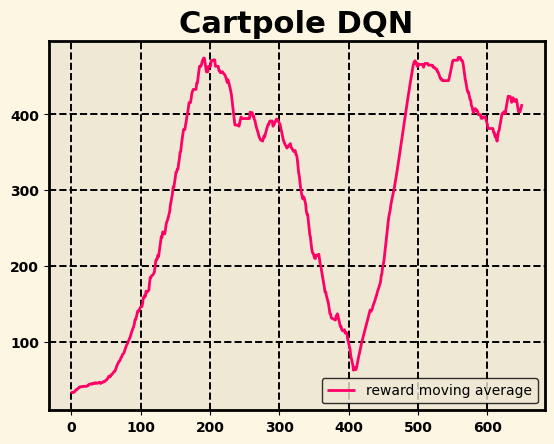

In [ ]:

def moving_average(data:list,interval):
    move_average=[]
    for i in range(interval,len(data)):
        move_average.append(np.mean(data[i-interval:i]))
    return move_average    
    
plt.style.use('Solarize_Light2')
plt.plot(moving_average(rewards,50),label="reward moving average",color="#ff0066")
plt.title("Cartpole DQN",color="black",fontsize=22,weight='bold')
plt.tick_params(axis='both', colors='black')
plt.grid(ls="--",lw=1.4,color="black")
plt.legend(frameon=True, edgecolor='black') 
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)
import os
# os.mkdir(f"./{ENV_NAME}/Plots/")
# Save high-quality PNG
plt.savefig(f"./{ENV_NAME}/Plots/plot_high_quality.png", dpi=300, bbox_inches='tight')

# Save high-quality SVG
plt.savefig(f"./{ENV_NAME}/Plots/plot_high_quality.svg", format='svg', bbox_inches='tight')   

<center><b>Final Exploit

In [18]:

env = gym.make(ENV_NAME,render_mode = "human")
obs,_ = env.reset()
rew = 0
done = False
while not done:
    
    obs = torch.tensor(obs).reshape(1,-1).float().to((device))
    with torch.no_grad():
        action_values = model(obs)
    action = torch.argmax(action_values).item()
    new_observation ,reward,terminated,truncated,_  = env.step(action) 
    obs= new_observation
    rew+=reward
    done =  truncated or terminated
print(rew)
env.close()

500.0
